<a href="https://colab.research.google.com/github/PeterRoumeliotis/AIFireSmokeDetectionResearchProject/blob/main/AIFireAndSmokeDetectionResearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Peter Roumeliotis**

In [ ]:
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, Input
import cv2
import numpy as np
import time
import kagglehub
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Downloading latest version of the dataset I am using
path = kagglehub.dataset_download("brsdincer/wildfire-detection-image-data")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/wildfire-detection-image-data


In [ ]:
random.seed(42)

# Getting the source paths
source_dir = '/kaggle/input/wildfire-detection-image-data/forest_fire/Training and Validation'
source_fire_dir = os.path.join(source_dir, 'fire')
source_non_fire_dir = os.path.join(source_dir, 'nofire')

# Creating training and validation paths
dest_dir = 'data'
train_fire_dir = os.path.join(dest_dir, 'train', 'fire')
val_fire_dir = os.path.join(dest_dir, 'validation', 'fire')
train_non_fire_dir = os.path.join(dest_dir, 'train', 'non_fire')
val_non_fire_dir = os.path.join(dest_dir, 'validation', 'non_fire')

# Making sure the directories exist and if they dont, making them
os.makedirs(train_fire_dir, exist_ok=True)
os.makedirs(val_fire_dir, exist_ok=True)
os.makedirs(train_non_fire_dir, exist_ok=True)
os.makedirs(val_non_fire_dir, exist_ok=True)

# 80% training 20% validation
split_ratio = 0.8

# Splitting the files into each folder
def split_data(source_folder, train_folder, val_folder, split_ratio=0.8):

    # List all items in source folder and keep only files
    file_list = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]
    # Randomizes it
    random.shuffle(file_list)

    # Figures out at what index to split the files
    split_point = int(len(file_list) * split_ratio)
    train_files = file_list[:split_point]   # Training
    val_files = file_list[split_point:]   # Validation

    # Copying files into training
    for file_name in train_files:
        src = os.path.join(source_folder, file_name)
        dst = os.path.join(train_folder, file_name)
        shutil.copy(src, dst)

    # Copying files into validation
    for file_name in val_files:
        src = os.path.join(source_folder, file_name)
        dst = os.path.join(val_folder, file_name)
        shutil.copy(src, dst)

split_data(source_fire_dir, train_fire_dir, val_fire_dir, split_ratio)
split_data(source_non_fire_dir, train_non_fire_dir, val_non_fire_dir, split_ratio)

print("Data is split")

Data is split


In [ ]:
img_width, img_height = 150, 150

batch_size = 32
epochs = 20

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

# Augmenting training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Rescaling validation data
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Generate validation batches
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

Found 2638 images belonging to 2 classes.
Found 662 images belonging to 2 classes.


# My Model

In [ ]:
from tensorflow.keras.optimizers import Adam
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_generator, validation_steps=validation_steps)

model_save_path = "fire_detection_cnn.keras"
model_googledrive_path = "/content/drive/MyDrive/fire_detection_cnn.keras"
model.save(model_googledrive_path)
model.save(model_save_path)
print(f"Model saved to {model_save_path} and {model_googledrive_path}")

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 314s 4s/step - accuracy: 0.8247 - loss: 0.3891 - val_accuracy: 0.4313 - val_loss: 1.6181
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 63s 774ms/step - accuracy: 0.6562 - loss: 0.4730 - val_accuracy: 0.4313 - val_loss: 1.5996
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 302s 4s/step - accuracy: 0.8286 - loss: 0.3662 - val_accuracy: 0.5109 - val_loss: 1.3194
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 62s 767ms/step - accuracy: 0.8438 - loss: 0.4168 - val_accuracy: 0.5250 - val_loss: 1.2966
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 301s 4s/step - accuracy: 0.8279 - loss: 0.3701 - val_accuracy: 0.6328 - val_loss: 0.8641
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 63s 773ms/step - accuracy: 0.9062 - loss: 0.2681 - val_accuracy: 0.6281 - val_loss: 0.8858
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 304s 4s/step - accuracy: 0.8372 - loss: 0.3735 - val_accuracy: 0.7812 - val_loss: 0.3988
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 64s 795ms/step - accuracy: 0.8438 - loss: 0.3934 - val_accuracy: 0.

In [ ]:
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.9 MB/s eta 0:00:00


In [ ]:
import os

# https://blog.roboflow.com/how-to-train-yolov8-on-a-custom-dataset/
# https://www.digitalocean.com/community/tutorials/train-yolov5-custom-data
# Sources I used to help me format my dataset for yolo

for split in ["train","validation"]:
    for cls_idx, cls in enumerate(["non_fire","fire"]):
        folder = f"data/{split}/{cls}"
        for img in os.listdir(folder):
            # Skips non images
            if not img.lower().endswith((".jpg",".png")): continue
            img_path   = os.path.join(folder, img)
            label_path = os.path.splitext(img_path)[0] + ".txt"

            if cls == "fire":
                with open(label_path, "w") as f:
                    # Formats data for yolo
                    f.write(f"{1} 0.5 0.5 1.0 1.0\n")
            else:
                open(label_path, "w").close()


In [ ]:
# Making YAML for yolo

# https://docs.ultralytics.com/
# https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/

# Used these sources for help

%%bash
cat <<EOF > data/fire_data.yaml
train: /content/data/train
val:   /content/data/validation

names:
  0: non_fire
  1: fire
EOF

echo "Created YAML:"
cat data/fire_data.yaml


Created YAML:
train: /content/data/train
val:   /content/data/validation

names:
  0: non_fire
  1: fire


In [ ]:
from ultralytics import YOLO

yolo = YOLO('yolov8n.pt')

yolo.train(
    data='data/fire_data.yaml',
    epochs=20,
    imgsz=150,
    batch=32,
    project='yolo-fire',
    name='exp'
)

yolo_model = YOLO('yolo-fire/exp/weights/best.pt')
yolo_model.save('/content/drive/MyDrive/best.pt')


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 73.7MB/s]


Ultralytics 8.3.128 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/fire_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=150, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrain

100%|██████████| 755k/755k [00:00<00:00, 13.9MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,238 parameters, 3,011,222 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 62.8MB/s]


AMP: checks passed ✅
WARNING ⚠️ imgsz=[150] must be multiple of max stride 32, updating to [160]
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1220.9±565.8 MB/s, size: 438.6 KB)


train: Scanning /content/data/train/fire... 2638 images, 1516 backgrounds, 0 corrupt: 100%|██████████| 2638/2638 [00:01<00:00, 1766.11it/s]

train: /content/data/train/fire/42848957940_cc5924c5ba_o.jpg: corrupt JPEG restored and saved
train: /content/data/train/fire/45600718572_9a9d934a92_o.jpg: corrupt JPEG restored and saved
train: /content/data/train/fire/50623063192_ec4f7f56b2_o.jpg: corrupt JPEG restored and saved
train: /content/data/train/non_fire/39728610281_68e77869f2_o.jpg: corrupt JPEG restored and saved


train: New cache created: /content/data/train/fire.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1456.5±2071.5 MB/s, size: 1988.7 KB)


val: Scanning /content/data/validation/fire... 662 images, 380 backgrounds, 0 corrupt: 100%|██████████| 662/662 [00:00<00:00, 1623.47it/s]

val: New cache created: /content/data/validation/fire.cache


Plotting labels to yolo-fire/exp/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 160 train, 160 val
Using 8 dataloader workers
Logging results to yolo-fire/exp
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.346G     0.4735      1.596      1.033         15        160: 100%|██████████| 83/83 [00:54<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.96it/s]

                   all        662        282      0.743       0.72      0.771      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20     0.426G     0.3305     0.7862     0.9488         26        160: 100%|██████████| 83/83 [00:43<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]


                   all        662        282      0.876      0.901      0.906       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20     0.443G     0.3047     0.6914     0.9334         24        160: 100%|██████████| 83/83 [00:39<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.12it/s]


                   all        662        282      0.487      0.833      0.583      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20     0.459G      0.301       0.68     0.9401         17        160: 100%|██████████| 83/83 [00:42<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.65it/s]

                   all        662        282       0.93      0.915      0.966       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20     0.477G      0.275     0.6168     0.9273         25        160: 100%|██████████| 83/83 [00:43<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.35it/s]

                   all        662        282      0.593      0.706      0.689      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20     0.492G     0.2467     0.5655     0.9234         23        160: 100%|██████████| 83/83 [00:41<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]

                   all        662        282      0.927      0.617      0.721      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      0.51G     0.2154      0.521     0.9089         22        160: 100%|██████████| 83/83 [00:46<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.06it/s]

                   all        662        282      0.875      0.908      0.925      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20     0.527G     0.2066     0.5139     0.9137         18        160: 100%|██████████| 83/83 [00:45<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.93it/s]

                   all        662        282      0.839      0.911      0.917      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20     0.545G      0.195     0.4858     0.9127         14        160: 100%|██████████| 83/83 [00:43<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.61it/s]

                   all        662        282      0.918      0.911      0.938      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20     0.561G     0.1812     0.4483     0.9024         18        160: 100%|██████████| 83/83 [00:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.79it/s]

                   all        662        282      0.976      0.901      0.959      0.923


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20     0.578G     0.1492     0.4791     0.9089          6        160: 100%|██████████| 83/83 [00:45<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.22it/s]


                   all        662        282      0.934      0.918      0.971      0.965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20     0.594G      0.128     0.3096     0.8966          4        160: 100%|██████████| 83/83 [00:40<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.86it/s]

                   all        662        282      0.985      0.957      0.989      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20     0.611G      0.112     0.2974     0.8977          3        160: 100%|██████████| 83/83 [00:42<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.72it/s]

                   all        662        282      0.985      0.945      0.991       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20     0.629G     0.1026     0.2576     0.8987          5        160: 100%|██████████| 83/83 [00:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.03it/s]

                   all        662        282      0.961      0.961      0.988      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20     0.646G     0.1019     0.2786      0.888          5        160: 100%|██████████| 83/83 [00:42<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.60it/s]

                   all        662        282      0.948       0.94      0.977      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20     0.662G    0.08346     0.2213     0.8804          6        160: 100%|██████████| 83/83 [00:44<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.01it/s]

                   all        662        282      0.954      0.926      0.986      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      0.68G    0.08212     0.2256     0.8814          7        160: 100%|██████████| 83/83 [00:42<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.47it/s]


                   all        662        282      0.985      0.961      0.988      0.985

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20     0.695G    0.07603     0.1837     0.8847          4        160: 100%|██████████| 83/83 [00:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.54it/s]

                   all        662        282      0.978      0.961      0.989      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20     0.713G    0.06885     0.1599     0.8757          6        160: 100%|██████████| 83/83 [00:41<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.14it/s]

                   all        662        282      0.983       0.95      0.991      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      0.73G    0.06048     0.1536     0.8731          7        160: 100%|██████████| 83/83 [00:41<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.68it/s]

                   all        662        282      0.977      0.965      0.991       0.99



20 epochs completed in 0.259 hours.
Optimizer stripped from yolo-fire/exp/weights/last.pt, 6.2MB
Optimizer stripped from yolo-fire/exp/weights/best.pt, 6.2MB

Validating yolo-fire/exp/weights/best.pt...
Ultralytics 8.3.128 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.50it/s]


                   all        662        282      0.985       0.95      0.992      0.991
                  fire        282        282      0.985       0.95      0.992      0.991
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to yolo-fire/exp


In [ ]:
cnn_model = tf.keras.models.load_model('fire_detection_cnn.keras')
yolo_model = YOLO('yolo-fire/exp/weights/best.pt')

# Upload/open vid
uploaded = files.upload()
video_path = next(iter(uploaded.keys()))
print(f"Video file: {video_path}")
cap = cv2.VideoCapture(video_path)

# Frames per second, default is 30
fps = cap.get(cv2.CAP_PROP_FPS) or 30.0

frame_indices = []  # Frame numbers
cnn_flags     = []  # My model
yolo_flags    = []  # Yolo

frame_idx = 0

# Loop through vid by frame
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_idx += 1

    # My model detection
    # Resize/normalize
    img = cv2.resize(frame, (150,150)) / 255.0
    # Get the fire probability from my model
    p = cnn_model.predict(np.expand_dims(img,0), verbose=0)[0][0]
    # Detect if probability > 0.5
    cnn_detected = (p > 0.5)

    # YOLO detection
    # Run yolo
    res = yolo_model(frame, verbose=False)[0]
    classes = res.boxes.cls.cpu().numpy().astype(int).tolist()
    # Detect if there is class 1 (fire)
    yolo_detected = (1 in classes)

    # Results
    frame_indices.append(frame_idx)
    cnn_flags.append(cnn_detected)
    yolo_flags.append(yolo_detected)

cap.release()


Saving YosemiteForestFire.mp4 to YosemiteForestFire.mp4
Video file: YosemiteForestFire.mp4


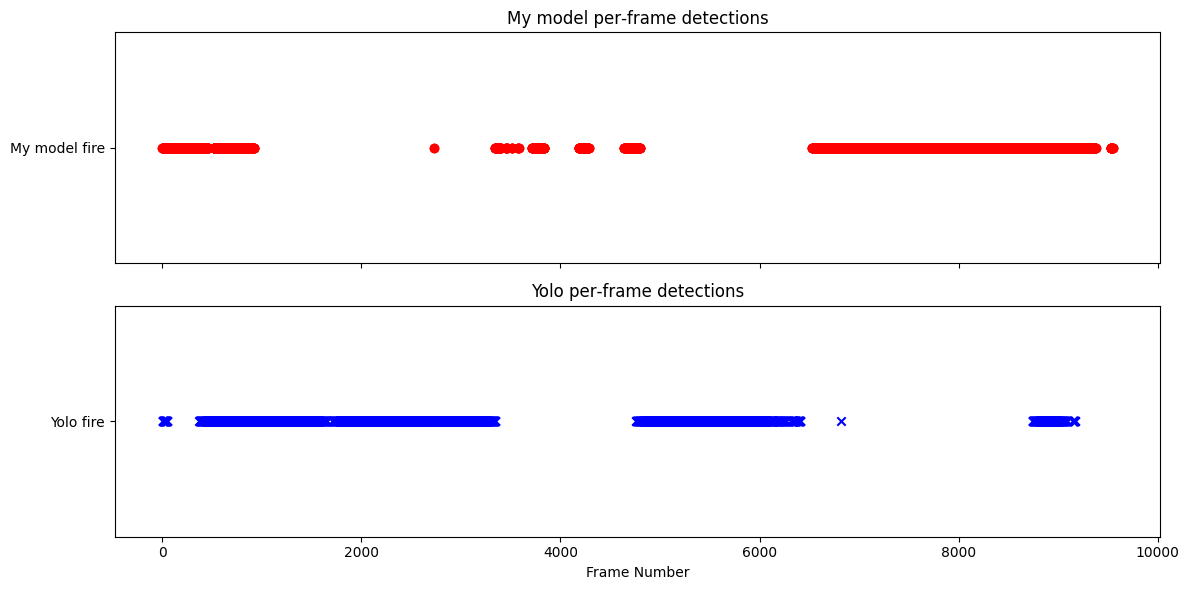

In [ ]:
# Plotting results
import matplotlib.pyplot as plt

cnn_frames = [frame_indices[i] for i, flag in enumerate(cnn_flags) if flag]
yolo_frames = [frame_indices[i] for i, flag in enumerate(yolo_flags) if flag]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# My model detections (red circles)
ax1.scatter(cnn_frames, [1]*len(cnn_frames),
            label='My model detected', marker='o', c='red')
ax1.set_yticks([1])
ax1.set_yticklabels(['My model fire'])
ax1.set_title('My model per‐frame detections')

# Yolo detections (blue X’s)
ax2.scatter(yolo_frames, [1]*len(yolo_frames),
            label='Yolo detected', marker='x', c='blue')
ax2.set_yticks([1])
ax2.set_yticklabels(['Yolo fire'])
ax2.set_title('Yolo per‐frame detections')

ax2.set_xlabel('Frame Number')
plt.tight_layout()
plt.show()


In [ ]:
# Referred to documentation to help teach me about all of this
# https://www.tensorflow.org/guide/keras/functional#convert_a_sequential_model_to_a_functional_model
# https://keras.io/examples/vision/grad_cam/
# https://docs.opencv.org/4.x/dd/d9e/classcv_1_1VideoWriter.html

sequential_model = load_model('fire_detection_cnn.keras')

# Using the last Conv2D layer
layer_name = 'conv2d_8'

# Building model to take frames of 150x150 that gets the activation of Conv2D and the prediction
inp = Input(shape=(150,150,3))
x = inp
conv_output = None
for layer in sequential_model.layers:
    x = layer(x)
    if layer.name == layer_name:
        conv_output = x
preds = x

# Making grad-CAM model
grad_model = Model(inputs=inp, outputs=[conv_output, preds])

# Upload video/open it
uploaded = files.upload()
video_path = next(iter(uploaded.keys()))
cap = cv2.VideoCapture(video_path)

# Frames per second
fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
# Width and height of frames
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# Needed to use codec to make file smaller in order to work and be able to store the video because it is too large
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# Output w/ file name
out = cv2.VideoWriter('cnn_gradcam_output.mp4', fourcc, fps, (w, h))

# Loops through every frame
frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret: break
    frame_count += 1

    # Preprocessing
    # Resize/Normalize
    small = cv2.resize(frame, (150,150)) / 255.0
    # Add batch dimension
    inp_arr = np.expand_dims(small, 0).astype(np.float32)

    with tf.GradientTape() as tape:
        # Recording sensor readings/fire probability
        conv_maps, pred = grad_model(inp_arr)
        # Watches them (Sees how changing maps affects the final score)
        tape.watch(conv_maps)
        # Loss is fire prob
        loss = pred[:,0]
    # Computes Gradient
    grads = tape.gradient(loss, conv_maps)

    # Building CAM
    weights = tf.reduce_mean(grads, axis=(0,1,2))
    cam = tf.reduce_sum(conv_maps[0] * weights, axis=-1)

    # Normalize CAM, wanting to make sure it is between 0 and 1 so its not negative number
    cam = tf.maximum(cam, 0)
    max_val = tf.reduce_max(cam)
    if max_val > 0:
        cam = cam / max_val
    else:
        cam = tf.zeros_like(cam)
    score = float(pred[0][0])

    # Overlay heatmap when model detects fire (greater than 50%)
    if score > 0.5:
        heat = (cam.numpy()*255).astype(np.uint8)
        heat = cv2.resize(heat, (w, h))
        heat = cv2.applyColorMap(heat, cv2.COLORMAP_HOT)
        frame = cv2.addWeighted(frame, 0.6, heat, 0.4, 0)

    # Annotate and write to the frames
    color = (0,0,255) if score>0.7 else (255,0,0)
    cv2.putText(frame, f"Fire: {score:.2f}", (10,30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    out.write(frame)

cap.release()
out.release()

print(f"Processed {frame_count} frames and saved as cnn_gradcam_output.mp4")

drive.mount('/content/drive')
shutil.copy('cnn_gradcam_output.mp4', '/content/drive/MyDrive/cnn_gradcam_output.mp4')
print("Also saved to Google Drive at MyDrive/cnn_gradcam_output.mp4")

Saving YosemiteForestFire.mp4 to YosemiteForestFire (1).mp4
Processed 9548 frames and saved as cnn_gradcam_output.mp4
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Also saved to Google Drive at MyDrive/cnn_gradcam_output.mp4
